In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from matplotlib import pyplot as plt

In [3]:
# Open the NetCDF file
file_path = 'G:/Other computers/My MacBook Air/Documents/School/MEnvSc/UTCDW Hackathon/TerraClimate.tmax.monthlymean.1980-2010.nc'  
nc_data = xr.open_dataset(file_path)

# Extract longitude and latitude values
EA_lon = nc_data.lon.values
EA_lat = nc_data.lat.values

# Create an xarray Dataset with lon and lat as coordinates
coords = {'lon': EA_lon, 'lat': EA_lat}
coords_ds = xr.Dataset(coords=coords)

# Convert the calendar if needed (optional)
#coords_ds_noleap = convert_calendar(coords_ds, 'noleap')

# Access the extracted variables if needed (optional)
#tas_obs_noleap = coords_ds_noleap.tas

# Display the coordinates dataset
print(coords_ds)

<xarray.Dataset> Size: 1kB
Dimensions:  (lon: 60, lat: 120)
Coordinates:
  * lon      (lon) float64 480B 32.02 32.06 32.1 32.15 ... 34.4 34.44 34.48
  * lat      (lat) float64 960B 15.98 15.94 15.9 15.85 ... 11.1 11.06 11.02
Data variables:
    *empty*


In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [5]:
df_ta = df.query("table_id == 'day' & source_id in ['AWI-CM-1-1-MR', 'CESM2', 'CanESM5', 'EC-Earth3', 'FGOALS-g3', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0'] & variable_id in ['tasmax'] & experiment_id == 'historical' & member_id =='r1i1p1f1'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
45209,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
98564,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429
205495,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190603
206446,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical...,NaN,20190610
206799,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20190614
222059,CMIP,MPI-M,MPI-ESM1-2-LR,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/hist...,NaN,20190710
277853,CMIP,CAS,FGOALS-g3,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-g3/historical...,NaN,20190826
425416,CMIP,EC-Earth-Consortium,EC-Earth3,historical,r1i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,NaN,20200310


In [11]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [12]:
# Get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta.zstore.values[0]
print(zstore)

gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/day/tasmax/gn/v20181218/


In [13]:
# Create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# Open it using xarray and zarr
file1 = xr.open_zarr(mapper, consolidated=True)
file1

<xarray.Dataset> Size: 18GB
Dimensions:    (lat: 192, bnds: 2, lon: 384, time: 60265)
Coordinates:
    height     float64 8B ...
  * lat        (lat) float64 2kB -89.28 -88.36 -87.42 ... 87.42 88.36 89.28
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
    lon_bnds   (lon, bnds) float64 6kB dask.array<chunksize=(384, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 482kB 1850-01-01T12:00:00 ... 2014-12-31...
    time_bnds  (time, bnds) datetime64[ns] 964kB dask.array<chunksize=(30133, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, lat, lon) float32 18GB dask.array<chunksize=(442, 192, 384), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54421.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/309d6a0d-1015-4f29-bdfb-7cdf6d8b33ae...
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/309d6a0d-1015-4f29-bdfb-7cdf6d8b33ae...
    version_id:             v20181218

In [18]:
# Select grid box nearest to the Toronto station latitude and longitude
tasmax_EA = file1.sel(lat= EA_lat, lon= EA_lon,method='nearest')

# Select time range using slicing
tasmax_EA_baseline = tasmax_EA.sel(time=slice("1980","2010")) - 273.15 # convert from Kelvin to degrees Celsius

# Load data. This step might take a minute or two.
tasmax_EA_baseline.load()

<xarray.Dataset> Size: 326MB
Dimensions:    (lat: 120, bnds: 2, lon: 60, time: 11323)
Coordinates:
    height     float64 8B 2.0
  * lat        (lat) float64 960B 16.36 16.36 15.43 15.43 ... 10.75 10.75 10.75
    lat_bnds   (lat, bnds) float64 2kB 15.9 16.83 15.9 ... 11.22 10.29 11.22
  * lon        (lon) float64 480B 31.88 31.88 31.88 31.88 ... 34.69 34.69 34.69
    lon_bnds   (lon, bnds) float64 960B 31.41 32.34 31.41 ... 35.16 34.22 35.16
  * time       (time) datetime64[ns] 91kB 1980-01-01T12:00:00 ... 2010-12-31T...
    time_bnds  (time, bnds) datetime64[ns] 181kB 1980-01-01 ... 2011-01-01
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, lat, lon) float32 326MB 34.96 34.96 34.96 ... 33.49 33.49
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54421.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/309d6a0d-1015-4f29-bdfb-7cdf6d8b33ae...
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/309d6a0d-1015-4f29-bdfb-7cdf6d8b33ae...
    version_id:             v20181218

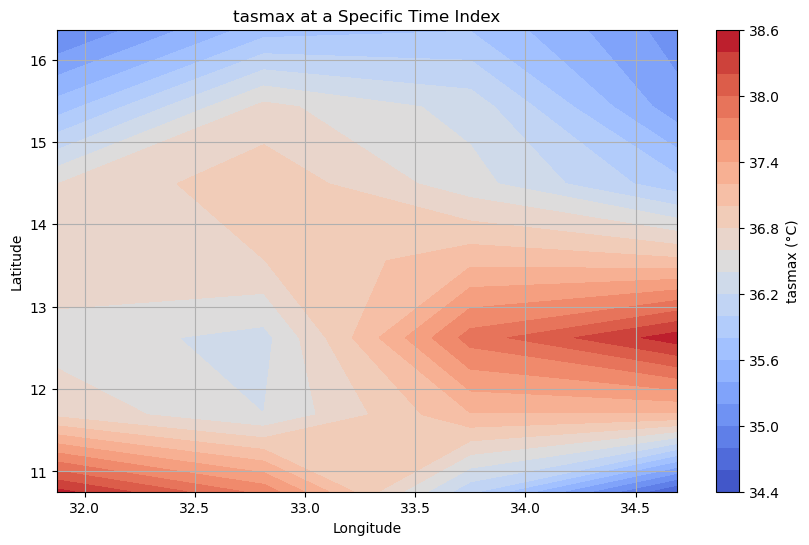

In [19]:
import matplotlib.pyplot as plt
import xarray as xr

# Assuming 'ds' is your xarray Dataset containing the 'tasmax' variable
# Replace 'ds' with your actual Dataset variable

# Select a specific time index for plotting, e.g., the first time step
time_idx = 0
tasmax_at_time = tasmax_EA_baseline['tasmax'].isel(time=time_idx)

# Create the plot using matplotlib's contourf function
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.contourf(tasmax_at_time.lon, tasmax_at_time.lat, tasmax_at_time, levels=20, cmap='coolwarm')  # Adjust colormap and levels as needed
plt.colorbar(label='tasmax (°C)')  # Add colorbar with label
plt.title('tasmax at a Specific Time Index')  # Add title
plt.xlabel('Longitude')  # Add x-axis label
plt.ylabel('Latitude')  # Add y-axis label
plt.grid(True)  # Add grid lines
plt.show()
